##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tweaking the Model

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l09c05_nlp_tweaking_the_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l09c05_nlp_tweaking_the_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this colab, you'll investigate how various tweaks to data processing and the model itself can impact results. At the end, you'll once again be able to visualize how the network sees the related sentiment of each word in the dataset.

## Import TensorFlow and related functions

In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Get the dataset

We'll once again use the dataset containing Amazon and Yelp reviews. This dataset was originally extracted from [here](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set).

In [3]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O /tmp/sentiment.csv

--2024-05-22 17:09:06--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.195.101, 74.125.195.102, 74.125.195.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2024-05-22 17:09:07--  https://drive.usercontent.google.com/download?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.197.132, 2607:f8b0:400e:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.197.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127831 (125K) [application/octet-stream]
Saving to: ‘/tmp/sentiment.csv’

/tmp/sentiment.csv  100%[===================>] 124.83K  --.-KB/s    in 0.002s  

2024-05-22 17:09:07 (51.9 MB

In [4]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Tokenize the dataset (with tweaks!)

Now, we'll tokenize the dataset, but we can make some changes to this from before. Previously, we used:
```
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
```

How might changing the `vocab_size`, `embedding_dim` or `max_length` affect how the model performs?

In [5]:
vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Train a Sentiment Model (with tweaks!)

We'll use a slightly different model here, using `GlobalAveragePooling1D` instead of `Flatten()`.

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 8109 (31.68 KB)
Trainable params: 8109 (31.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
num_epochs = 30
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 8s 92ms/step - loss: 0.6923 - accuracy: 0.5223 - val_loss: 0.6977 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 2s 40ms/step - loss: 0.6907 - accuracy: 0.5223 - val_loss: 0.7000 - val_accuracy: 0.4110
Epoch 3/30
50/50 [==============================] - 1s 19ms/step - loss: 0.6888 - accuracy: 0.5223 - val_loss: 0.6992 - val_accuracy: 0.4135
Epoch 4/30
50/50 [==============================] - 1s 13ms/step - loss: 0.6852 - accuracy: 0.5298 - val_loss: 0.6985 - val_accuracy: 0.4336
Epoch 5/30
50/50 [==============================] - 1s 24ms/step - loss: 0.6764 - accuracy: 0.5669 - val_loss: 0.6877 - val_accuracy: 0.5013
Epoch 6/30
50/50 [==============================] - 1s 12ms/step - loss: 0.6641 - accuracy: 0.6183 - val_loss: 0.6863 - val_accuracy: 0.4837
Epoch 7/30
50/50 [==============================] - 1s 13ms/step - loss: 0.6465 - accuracy: 0.6541 - val_loss: 0.6712 - val_accuracy: 0.5388
Epoch 8/30
50

## Visualize the training graph

You can use the code below to visualize the training and validation accuracy while you try out different tweaks to the hyperparameters and model.

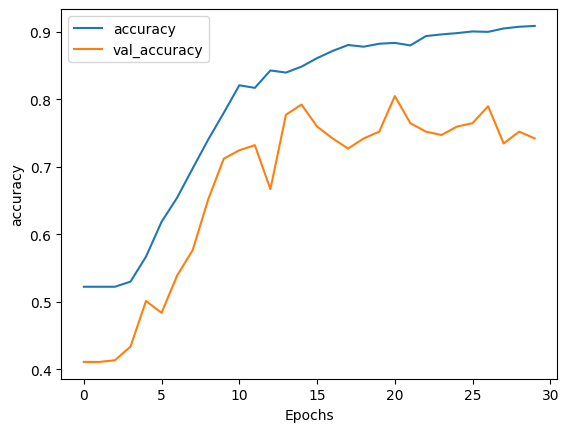

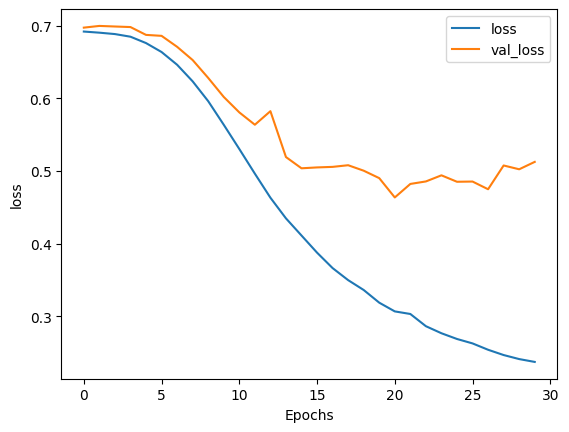

In [8]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Get files for visualizing the network

The code below will download two files for visualizing how your network "sees" the sentiment related to each word. Head to http://projector.tensorflow.org/ and load these files, then click the checkbox to "sphereize" the data.

Note: You may run into errors with the projection if your `vocab_size` earlier was larger than the actual number of words in the vocabulary, in which case you'll need to decrease this variable and re-train in order to visualize.

In [9]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(500, 16)


In [10]:
import io

# Create the reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [11]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Predicting Sentiment in New Reviews

Below, we've again included some example new reviews you can test your results on.

In [12]:
# Use the model to predict a review
fake_reviews = ['I love this phone', 'I hate spaghetti',
                'Everything was cold',
                'Everything was hot exactly as I wanted',
                'Everything was green',
                'the host seated us immediately',
                'they gave us free chocolate cake',
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes',
                'does not work when I stand on my head']

print(fake_reviews)

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  print(classes[x])
  print('\n')

# Try adding reviews of your own
# Add some negative words (such as "not") to the good reviews and see what happens
# For example:
# they gave us free chocolate cake and did not charge us

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'does not work when I stand on my head']

HOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!

1/1 [==============================] - 0s 73ms/step
I love this phone
[0.953804]


I hate spaghetti
[0.13450521]


Everything was cold
[0.63538325]


Everything was hot exactly as I wanted
[0.44485864]


Everything was green
[0.63538325]


the host seated us immediately
[0.6200993]


they gave us free chocolate cake
[0.9057402]


not sure about the wilted flowers on the table
[0.0664558]


only works when I stand on tippy toes
[0.9384208]


does not work when I stand on my head
[0.04295923]


